# Classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Features engineering


In [47]:
# Import data
users = pd.read_csv('data/train_users_2.csv')
test_users = pd.read_csv('data/test_users.csv')
sessions = pd.read_csv('data/sessions.csv')

# Add labels DF/NDF
users['destination_found'] = users.apply(lambda r: 'NDF' if r['country_destination'] == 'NDF' else 'DF', axis=1)

# Retain users that have a session & add information about their session
sessions_naless = sessions.fillna('_')
sessions['action_name'] = sessions_naless['action'] + '-' + sessions_naless['action_type'] + '-' + sessions_naless['action_detail']
users_sessions = sessions.groupby('user_id').agg({
    "action_name": pd.Series.tolist,
    'secs_elapsed': lambda r: round(r.sum() / (60**2), 0),
})
users_sessions = users_sessions.rename({"secs_elapsed":"hours_elapsed", "action_name":"actions",}, axis=1)
users = users_sessions.reset_index().rename({'user_id':'id'}, axis=1).merge(users, how='inner', on='id')

# Make dataset balanced by keeping the smae number users in each classes
# n = min(users[users['destination_found'] == 'NDF'].shape[0], users[users['destination_found'] == 'DF'].shape[0])
# users = pd.concat([users[users['destination_found'] == 'NDF'].head(n), users[users['destination_found'] == 'DF'].head(n)]).sample(frac=1).reset_index(drop=True)
users = users.sort_values('id')

In [48]:
print("users.head : ", users.shape)
users.tail()

users.head :  (73815, 19)


,id,actions,hours_elapsed,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination,destination_found
73810,zzx5wp3lqu,"[personalize-data-wishlist_content_update, sim...",143.0,2014-05-22,20140522105222,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,Firefox,NDF,NDF
73811,zzy7t0y9cm,"[personalize-data-wishlist_content_update, hea...",20.0,2014-03-27,20140327185345,2014-03-29,-unknown-,NaN,basic,0,en,sem-brand,google,omg,Web,Windows Desktop,Chrome,US,DF
73812,zzysuoqg6x,"[hosting_social_proof--unknown---unknown-, cre...",0.0,2014-01-08,20140108221010,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Windows Desktop,IE,NDF,NDF
73813,zzywmcn0jv,"[header_userpic-data-header_userpic, personali...",597.0,2014-02-21,20140221160109,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,iPhone,Mobile Safari,NDF,NDF
73814,zzzlylp57e,"[similar_listings-data-similar_listings, show-...",120.0,2014-06-11,20140611074639,2014-06-24,-unknown-,NaN,basic,0,en,seo,google,linked,Web,Windows Desktop,Chrome,FR,DF


In [49]:
# Converting date string into datetime object
users['timestamp_first_active'] = pd.to_datetime(users['timestamp_first_active'], format='%Y%m%d%H%M%S')
users['date_account_created'] = pd.to_datetime(users['date_account_created'], format='%Y-%m-%d')
users["date_first_booking"] = pd.to_datetime(users['date_first_booking'], format='%Y-%m-%d')
users['date_first_active'] = pd.to_datetime(users['timestamp_first_active'].dt.date, format='%Y-%m-%d')
users['hour_first_active'] = users['timestamp_first_active'].dt.hour
users['month_first_active'] = users['date_first_active'].dt.month
users['year_first_active'] = users['date_first_active'].dt.year

In [50]:
def process_age(age):
    if age > 1000:
        return 2015 - age
    elif age == 105:
        return -2
    elif age < 100:
        return age
    else: 
        return -1

# Bucketize age variable
users['age'] = users.apply(lambda r: process_age(r['age']), axis=1)
users['age_group'] = sum([(users['age'] < 0).astype(int),
    (users['age'] < 18).astype(int),
    (users['age'] < 25).astype(int),
    (users['age'] < 30).astype(int),
    (users['age'] < 35).astype(int),
    (users['age'] < 40).astype(int),
    (users['age'] < 60).astype(int),
    (users['age'] < 100).astype(int)])

In [51]:
def process_signup_flow(num_page):
    if num_page <= 3:
        return num_page
    elif 3 < num_page < 12:
        return 'middle'
    else:
        return 12
    
# Bucketize signup_flow
users['signup_flow_group'] = users.apply(lambda r: process_signup_flow(r['signup_flow']), axis=1)

In [52]:
# Bucketize language
users['language_group'] = (users['language'] == 'en').astype(int)

In [53]:
# Only retains browser which have a large enough set of users
users_browsers = users.groupby('first_browser').count()[['id']].sort_values(by='id')
browsers = set(users_browsers[users_browsers['id'] > 1000].index)
users['first_browser_processed'] = users.apply(lambda r: r['first_browser'] if r['first_browser'] in browsers else 'Other', axis=1)

In [54]:
# Fill Nan in first_affiliate_tracked
users['first_affiliate_tracked'] = users['first_affiliate_tracked'].fillna('-unknown-')

In [85]:
# Most use device type (phone or pc)
devices = sessions.groupby('user_id').agg({'device_type': lambda r: r.values.tolist(),}).reset_index().rename({'user_id':'id'}, axis=1)
devices['most_use'] = devices.apply(lambda r: max(set(r['device_type']), key = r['device_type'].count), axis=1)

phones = ['iPhone', 'iPad Tablet', 'Android App Unknown Phone/Tablet', 'Android Phone', 'Tablet', 'Chromebook', 'Blackberry',
          'Windows Phone', 'Opera Phone', 'iPodtouch']
pcs = ['Mac Desktop', 'Windows Desktop', 'Linux Desktop']

def most_use2group(most_use):
    exp = most_use.split('_count')[0]  # Remove _count suffix
    if exp in phones:
        return 'phone'
    elif exp in pcs:
        return 'pc'
    else:
        return '-unknown-'
    
devices['most_use_device_group'] = devices.apply(lambda r: most_use2group(r['most_use']), axis=1)
devices.drop('most_use', axis=1)
users = users.merge(devices, on='id', how='inner')

In [55]:
# Bucketize number of hours elasped
users['hours_elapsed_group'] = sum([(users['hours_elapsed'] < 0).astype(int),
    (users['hours_elapsed'] < 50).astype(int),
    (users['hours_elapsed'] < 100).astype(int),
    (users['hours_elapsed'] < 150).astype(int),
    (users['hours_elapsed'] < 200).astype(int),
    (users['hours_elapsed'] < 250).astype(int),
    (users['hours_elapsed'] < 300).astype(int),])

In [56]:
# Bucketize number of unique actions
users['nb_unique_actions'] = users.apply(lambda r: len(set(r['actions'])), axis=1)
users['nb_unique_actions_group'] = sum([(users['nb_unique_actions'] < 14).astype(int),
    (users['nb_unique_actions'] < 16).astype(int),
    (users['nb_unique_actions'] < 18).astype(int),
    (users['nb_unique_actions'] < 20).astype(int),
    (users['nb_unique_actions'] < 22).astype(int),
    (users['nb_unique_actions'] < 24).astype(int),])

In [57]:
relevent_action_names = ['requested-submit-post_checkout_action',
 'requested-view-p5',
 'pending-booking_request-pending',
 'agree_terms_check--unknown---unknown-',
 'at_checkpoint-booking_request-at_checkpoint',
 'ajax_photo_widget_form_iframe--unknown---unknown-',
 'complete_status--unknown---unknown-',
 'complete_redirect--unknown---unknown-',
 'travel_plans_current-view-your_trips',
 'populate_from_facebook--unknown---unknown-',
 'social_connections-data-user_social_connections',
 'create-submit-signup',
 'update-submit-update_listing_description',
 'manage_listing-view-manage_listing',
 'set_user-submit-create_listing']


# Encode actions
one_hot_encoded_actions = pd.get_dummies(sessions[sessions['action_name'].isin(relevent_action_names)][['user_id', 'action_name']], columns=['action_name'])

# Generate functions for aggretation
columns = one_hot_encoded_actions.columns.values.tolist()
columns.remove('user_id')
agg_funcs = {col_name: sum for col_name in columns}

# Aggretate actions by users
actions_matrix = one_hot_encoded_actions.groupby('user_id').agg(agg_funcs)

# Selecting the most relevent columns
cols = ['action_name_' + name for name in relevent_action_names]
m = actions_matrix[cols].div(actions_matrix[cols].std(axis=1), axis=0).fillna(0)
m.head(3)

,action_name_requested-submit-post_checkout_action,action_name_requested-view-p5,action_name_pending-booking_request-pending,action_name_agree_terms_check--unknown---unknown-,action_name_at_checkpoint-booking_request-at_checkpoint,action_name_ajax_photo_widget_form_iframe--unknown---unknown-,action_name_complete_status--unknown---unknown-,action_name_complete_redirect--unknown---unknown-,action_name_travel_plans_current-view-your_trips,action_name_populate_from_facebook--unknown---unknown-,action_name_social_connections-data-user_social_connections,action_name_create-submit-signup,action_name_update-submit-update_listing_description,action_name_manage_listing-view-manage_listing,action_name_set_user-submit-create_listing
user_id,,,,,,,,,,,,,,,
00023iyk9l,0.0,3.687958,0.737592,0.0,0.00000,0.0,0.0,0.0,1.475183,0.000000,0.000000,0.000000,0.0,0.0,0.0
001wyh0pz8,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,3.567530,1.783765,0.0,0.0,0.0
002qnbzfs5,0.0,0.000000,0.000000,0.0,0.05384,0.0,0.0,0.0,0.000000,0.000000,3.876457,0.000000,0.0,0.0,0.0
00389675gq,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,2.841993,2.841993,0.000000,0.0,0.0,0.0
003iamz20l,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,3.880072,0.129336,0.0,0.0,0.0


In [86]:
users_final = users.merge(m.round(0).reset_index().rename({'user_id':'id'}, axis=1), how='left', on='id').fillna(0)

# Selecting features
features = ['month_first_active', 'year_first_active', 'gender', 'age_group', 'signup_method', 'signup_flow_group',  'affiliate_provider', 
           'signup_app', 'first_browser_processed',
           'hours_elapsed_group', 'nb_unique_actions_group', 'most_use_device_group']

features += ['action_name_' + name for name in relevent_action_names]

data = users_final[features].copy()

X = pd.get_dummies(data)
y = users_final['destination_found'].values
# y = users['country_destination'].values

In [83]:
data.shape

(73815, 27)

## Training model

In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Weights inverted for conter-balancing
nb_NDF = y.tolist().count('DF')
nb_DF = y.tolist().count('NDF')
class_weight = {'DF': nb_DF/y.shape[0],
               'NDF': nb_NDF/y.shape[0]}
model = RandomForestClassifier(n_estimators=50, max_depth=16, class_weight=class_weight)
res = cross_val_score(model, X=X, y=y)
print(f"Mean score : {np.mean(res)}")
print(f"Std score : {np.std(res)}")

Mean score : 0.763435616067195
Std score : 0.0017499735941159111


[[0.72876235 0.27123765]
 [0.21802068 0.78197932]]


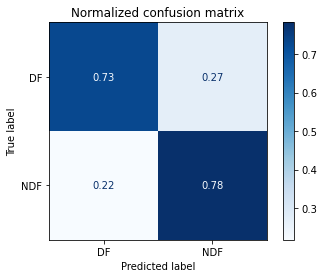

In [88]:
from sklearn.metrics import plot_confusion_matrix
n = int(X.shape[0] * 0.7)
model.fit(X[:n], y[:n])

# Plot non-normalized confusion matrix
disp = plot_confusion_matrix(model, X[n:], y[n:], cmap=plt.cm.Blues, normalize='true')
disp.ax_.set_title("Normalized confusion matrix")
print(disp.confusion_matrix)